In [2]:
%pylab inline
import rlcompleter, readline
readline.parse_and_bind('tab: complete')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import cv2

Populating the interactive namespace from numpy and matplotlib


In [3]:
allfiles = glob.glob("../data/Q2/Roadsign/*.jpg")
roadsign_imgs = [plt.imread(file) for file in allfiles]
roadsign_template = roadsign_imgs[-1]
roadsign_data = roadsign_imgs[:-1]

In [4]:
allfiles = glob.glob("../data/Q2/Starbucks/*.jpg")
starbuck_imgs = [plt.imread(file) for file in allfiles]
starbuck_template = starbuck_imgs[-1]
starbuck_data = starbuck_imgs[:-1]
#plt.imshow(starbuck_template)

In [5]:
allfiles = glob.glob("../data/Q2/Superman/*.jpg")
superman_imgs = [plt.imread(file) for file in allfiles]
superman_template = superman_imgs[-1]
superman_data = superman_imgs[:-1]


In [86]:
def draw_keypoints(query, train):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1,des1 = sift.detectAndCompute(query,None)
    img1=cv2.drawKeypoints(query,kp1,outImage=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    kp2,des2 = sift.detectAndCompute(train,None)
    img2=cv2.drawKeypoints(train,kp2,outImage=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return [img1,kp1,des1],[img2,kp2,des2]

def find_goodmatch(query, train, threshold):
    
    [img1,kp1,des1],[img2,kp2,des2] = draw_keypoints(query,train)
    
   
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < threshold*n.distance:
            good.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    result = cv2.drawMatchesKnn(query,kp1,train,kp2,good,outImg=2,flags=2)
    
    return result,good,kp1,kp2

def match_template(query, train, threshold):
    """
    Find template object in scene img
    """
    good,kp1,kp2 = find_goodmatch(query,train, threshold)[1:]
    
    if len(good)> 1:
        src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts)# cv2.RANSAC,5.0
        matchesMask = mask.ravel().tolist()

        h,w = query.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        result = cv2.polylines(train.copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    return result


In [346]:
for i,img in enumerate(roadsign_data):
    result = match_template(roadsign_template,img,0.68)
    plt.imsave('../result/roadsign_sift+homography_'+str(i)+'.png',result)

In [356]:
for i,img in enumerate(starbuck_data):
    result = match_template(starbuck_template,img,0.8)
    plt.imsave('../result/starbuck_sift+homography_'+str(i)+'.png',result)

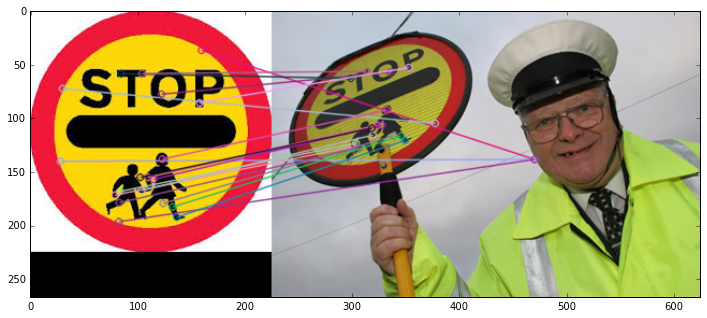

In [38]:
match = find_goodmatch(roadsign_template,roadsign_data[12],0.68)
plt.figure(figsize=(12,8))
plt.imshow(match[0])

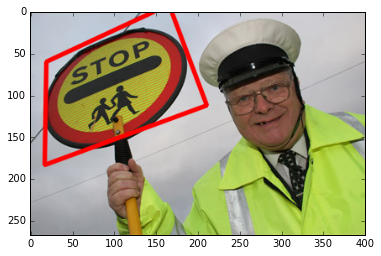

In [39]:
result = match_template(roadsign_template,roadsign_data[12],0.68)
plt.imshow(result)

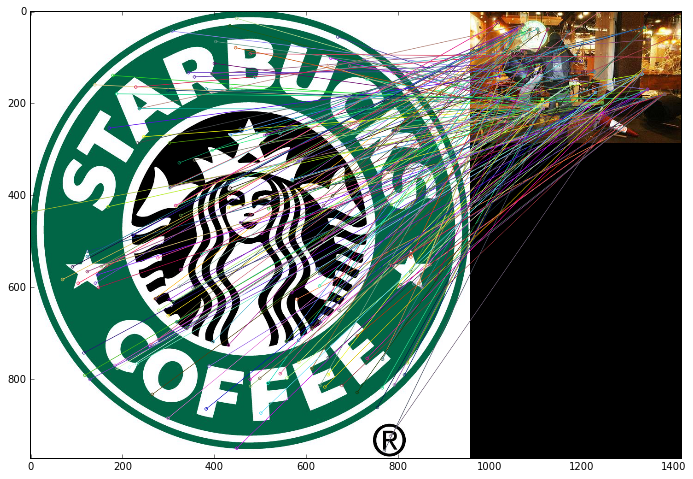

In [68]:
match = find_goodmatch(starbuck_template,starbuck_data[12],0.9)
plt.figure(figsize=(12,8))
plt.imshow(match[0])

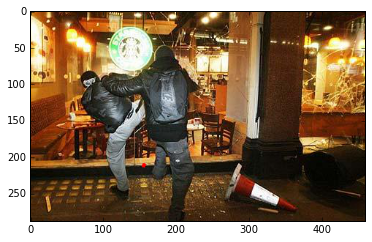

In [69]:
result = match_template(starbuck_template,starbuck_data[12],0.9)
plt.imshow(result)

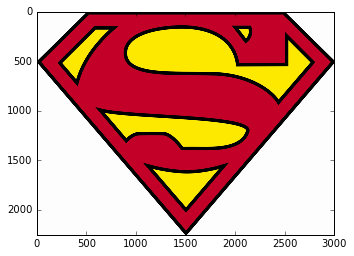

In [107]:
blur = cv2.GaussianBlur(superman_template,(5,5),1000)
plt.imshow(blur)

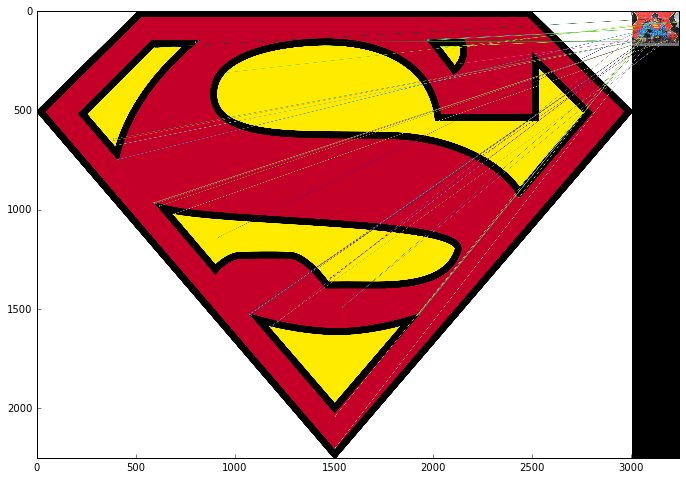

In [93]:

match = find_goodmatch(superman_template,superman_data[5],0.9)
plt.figure(figsize=(12,8))
plt.imshow(match[0])

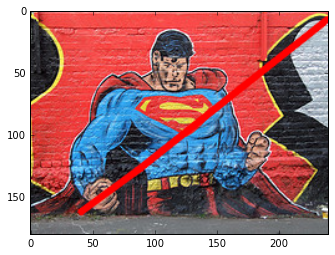

In [95]:
result = match_template(superman_template,superman_data[5],0.9)
plt.imshow(result)